Домашняя работа к семинару от 13 февраля 2024 года:
1. Поиграться с кодом соревнования по Северстали, получить как можно лучший результат.

Сдавать как обычно блокнот.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout
import cv2

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GeekBrains_seminar_13-02-2024/train.csv')

In [4]:
data

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [5]:
data.shape

(7095, 3)

Т.к. бесплатные вычислительные ресурсы ограничены, то из всего набора данных выбраны только 1000 изображений.

In [7]:
l1=[]
l2=[]
for img,ClassId,EncodedPixels in tqdm(data.values[0:1000]):
    image=cv2.imread("/content/drive/MyDrive/Colab Notebooks/GeekBrains_seminar_13-02-2024/train_images/{}".format(img),cv2.IMREAD_COLOR)
    image=cv2.resize(image,(120,120))
    l1.append(image)
    l2.append(ClassId)

100%|██████████| 1000/1000 [06:42<00:00,  2.49it/s]


Проверка изображений случайной стали, чтобы проверить, дефектна ли она или нет.

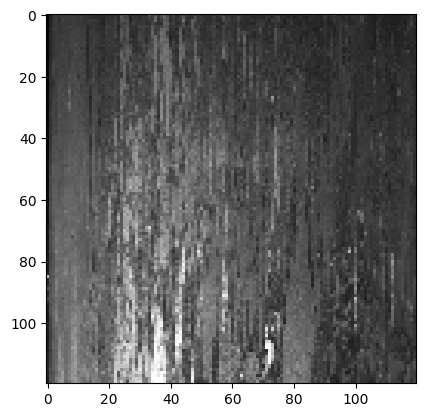

In [8]:
i = 15
plt.imshow(l1[i])

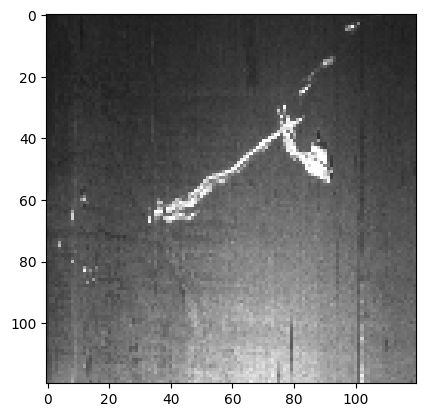

In [9]:
i = 16
plt.imshow(l1[i])

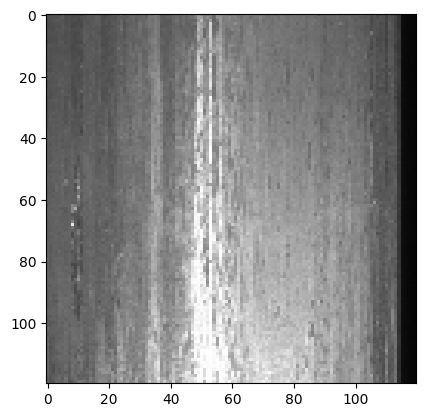

In [10]:
i = 90
plt.imshow(l1[i])

Выполним one-hot кодировку

In [11]:
encoder = LabelEncoder()

X= np.array(l1)
X = X/255

y = encoder.fit_transform(l2)
y = np.array(y)


In [12]:
X.shape

(1000, 120, 120, 3)

In [13]:
y.shape

(1000,)

# Борьба с дибалансом

для борьбы с дисбалансом выполним случайное сэмплирование

In [14]:
from imblearn.over_sampling import RandomOverSampler
reshaped_X = X.reshape(X.shape[0],-1)
oversample = RandomOverSampler(sampling_strategy='not majority')
X, y  = oversample.fit_resample(reshaped_X , y)
X = X.reshape(-1,120,120,3)

In [15]:
X.shape

(2844, 120, 120, 3)

In [16]:

y = to_categorical(y)

In [17]:
y

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

разделим на тренировку и валидацию

In [18]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,shuffle=True)

In [19]:
print("x_train размер:",X_train.shape)
print("x_test размер:",X_test.shape)
print("y_train размер:",y_train.shape)
print("y_test размер:",y_test.shape)

x_train размер: (2275, 120, 120, 3)
x_test размер: (569, 120, 120, 3)
y_train размер: (2275, 4)
y_test размер: (569, 4)


# Построение собственной нейронной сети из трех сверточных слоев

In [21]:
my_model = Sequential()
my_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(120, 120, 3)))
my_model.add(MaxPooling2D((2, 2)))
my_model.add(Conv2D(64, (3, 3), activation='relu'))
my_model.add(MaxPooling2D((2, 2)))
my_model.add(Conv2D(128, (3, 3), activation='relu'))
my_model.add(MaxPooling2D((2, 2)))
my_model.add(Flatten())
my_model.add(Dense(64, activation='relu'))
my_model.add(Dense(4, activation='softmax'))

In [22]:
my_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
my_history = my_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_train, y_train))

Epoch 1/10
72/72 [==============================] - 84s 1s/step - loss: 1.0417 - accuracy: 0.5147 - val_loss: 0.9052 - val_accuracy: 0.6009
Epoch 2/10
72/72 [==============================] - 91s 1s/step - loss: 0.8219 - accuracy: 0.6286 - val_loss: 0.6988 - val_accuracy: 0.7231
Epoch 3/10
72/72 [==============================] - 71s 983ms/step - loss: 0.6742 - accuracy: 0.7143 - val_loss: 0.5919 - val_accuracy: 0.7121
Epoch 4/10
72/72 [==============================] - 78s 1s/step - loss: 0.5484 - accuracy: 0.7807 - val_loss: 0.4623 - val_accuracy: 0.8391
Epoch 5/10
72/72 [==============================] - 75s 1s/step - loss: 0.4872 - accuracy: 0.8189 - val_loss: 0.3734 - val_accuracy: 0.8607
Epoch 6/10
72/72 [==============================] - 70s 973ms/step - loss: 0.3960 - accuracy: 0.8479 - val_loss: 0.2941 - val_accuracy: 0.8862
Epoch 7/10
72/72 [==============================] - 74s 1s/step - loss: 0.2923 - accuracy: 0.8971 - val_loss: 0.2566 - val_accuracy: 0.9248
Epoch 8/10
72/

<Axes: title={'center': 'Accuracy for my curve'}>

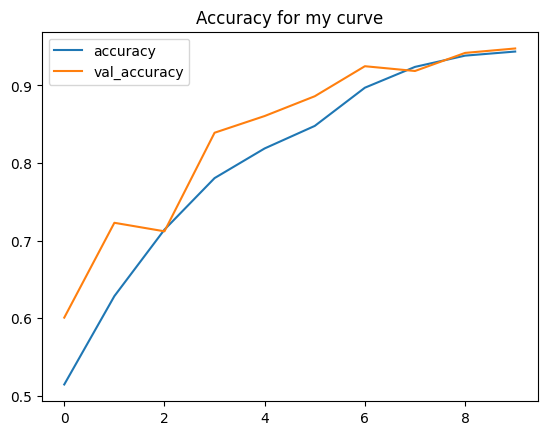

In [27]:
my_history_df = pd.DataFrame(my_history.history)
my_history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy for my curve')

<Axes: title={'center': 'Loss curve'}>

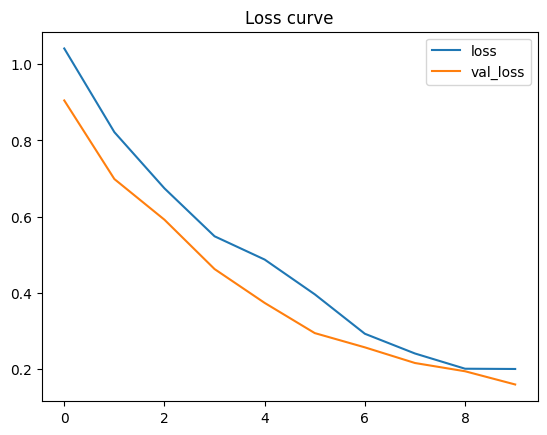

In [28]:
my_history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

# Проверка собственной модели

In [42]:
my_result = my_model.evaluate(X_test, y_test)

loss = my_result[0]
accuracy = my_result[1]
print(f"[+] Accuracy: {accuracy*100:.2f}%")

18/18 [==============================] - 4s 193ms/step - loss: 0.3757 - accuracy: 0.8858
[+] Accuracy: 88.58%


# Архитектура созданной собственной нейронной сети

In [43]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 28, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 128)      

# Тестирование собственной модели на новых примерах

In [55]:
l2[:5]

[1, 3, 1, 4, 3]

In [56]:
X= np.array(l1[:5])
X = X/255

y = encoder.fit_transform(l2[:5])
y = np.array(y)

In [57]:
y =  to_categorical(y)
y

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [58]:
predictions = my_model.predict(X)
predictions

1/1 [==============================] - 0s 47ms/step


array([[9.4042563e-01, 7.2858686e-04, 5.8218632e-02, 6.2717852e-04],
       [1.6563524e-02, 1.5058573e-03, 9.7896010e-01, 2.9704650e-03],
       [9.5756942e-01, 6.3691795e-04, 3.8053844e-02, 3.7397512e-03],
       [3.6314848e-06, 5.4341798e-11, 2.7400639e-02, 9.7259575e-01],
       [9.9034980e-03, 5.9270896e-03, 9.8416924e-01, 1.4838876e-07]],
      dtype=float32)

# Выводы о работе предложенной модели:
1. Точность модели составила 0.9477, что выше, чем для вариантов трех-, пяти- и тринадцатислойных моделей, рассмотренных на семинаре.
2. Предложенная модель правильно определила 5-ть образцов стали из 5-ти предложенных.

# Построение нейронной сети  в 3 слоя и график обучения

In [ ]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model.add(Flatten())
model.add(Dense(4,activation="softmax"))

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [ ]:
history = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1)

Epoch 1/10
129/129 [==============================] - 81s 619ms/step - loss: 1.5038 - accuracy: 0.6184 - val_loss: 0.6306 - val_accuracy: 0.7515
Epoch 2/10
129/129 [==============================] - 78s 605ms/step - loss: 0.4867 - accuracy: 0.8254 - val_loss: 0.4280 - val_accuracy: 0.8587
Epoch 3/10
129/129 [==============================] - 78s 607ms/step - loss: 0.3264 - accuracy: 0.8989 - val_loss: 0.3734 - val_accuracy: 0.8714
Epoch 4/10
129/129 [==============================] - 78s 603ms/step - loss: 0.2546 - accuracy: 0.9255 - val_loss: 0.3579 - val_accuracy: 0.8835
Epoch 5/10
129/129 [==============================] - 78s 605ms/step - loss: 0.2188 - accuracy: 0.9388 - val_loss: 0.3155 - val_accuracy: 0.9068
Epoch 6/10
129/129 [==============================] - 78s 604ms/step - loss: 0.1987 - accuracy: 0.9462 - val_loss: 0.2865 - val_accuracy: 0.9138
Epoch 7/10
129/129 [==============================] - 78s 606ms/step - loss: 0.1770 - accuracy: 0.9538 - val_loss: 0.2813 - val_ac

<Axes: title={'center': 'Loss curve'}>

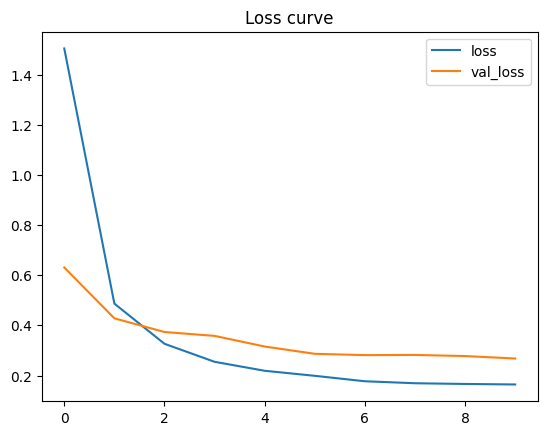

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

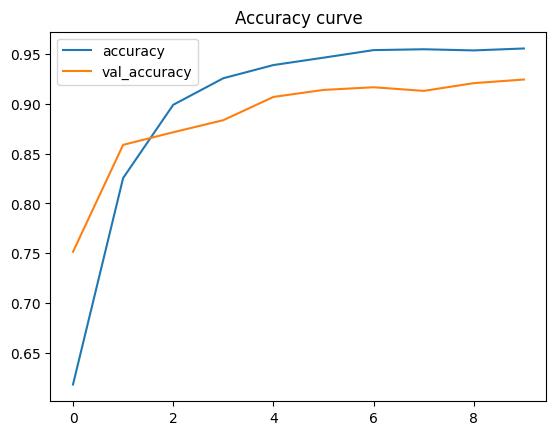

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

# Построение нейронной сети  в 5 слоев

In [29]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(4,activation="softmax"))


In [30]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [31]:
history = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1)

Epoch 1/10
18/18 [==============================] - 29s 2s/step - loss: 2.0036 - accuracy: 0.4004 - val_loss: 0.9708 - val_accuracy: 0.5694
Epoch 2/10
18/18 [==============================] - 27s 2s/step - loss: 0.8407 - accuracy: 0.6501 - val_loss: 0.7849 - val_accuracy: 0.6696
Epoch 3/10
18/18 [==============================] - 27s 2s/step - loss: 0.6596 - accuracy: 0.7424 - val_loss: 0.6467 - val_accuracy: 0.7241
Epoch 4/10
18/18 [==============================] - 27s 2s/step - loss: 0.5235 - accuracy: 0.8105 - val_loss: 0.5546 - val_accuracy: 0.7979
Epoch 5/10
18/18 [==============================] - 29s 2s/step - loss: 0.3963 - accuracy: 0.8853 - val_loss: 0.4892 - val_accuracy: 0.8330
Epoch 6/10
18/18 [==============================] - 29s 2s/step - loss: 0.3176 - accuracy: 0.9108 - val_loss: 0.4688 - val_accuracy: 0.8489
Epoch 7/10
18/18 [==============================] - 27s 1s/step - loss: 0.2590 - accuracy: 0.9288 - val_loss: 0.3860 - val_accuracy: 0.8541
Epoch 8/10
18/18 [==

<Axes: title={'center': 'Loss curve'}>

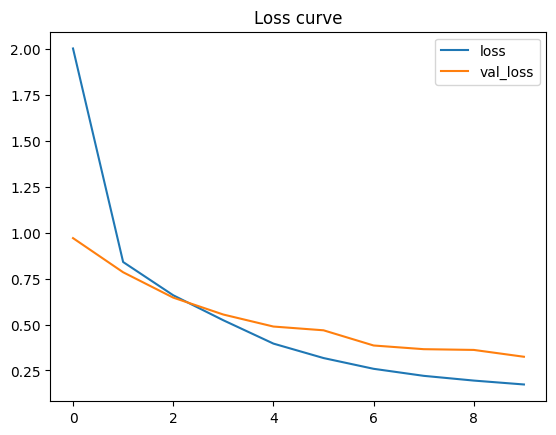

In [32]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

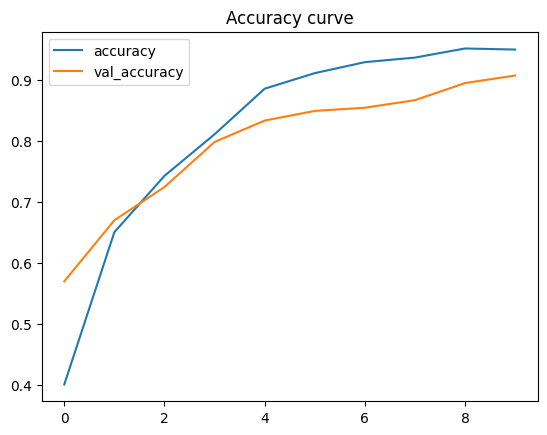

In [33]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

# Построение нейронной сети в 13 слоев и обучение

In [34]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(256,activation="relu"))
model.add(Dense(4,activation="softmax"))

In [ ]:
# early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,min_delta=0.001,restore_best_weights=True)

Сборка и обучение модели

In [35]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [36]:
history = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1)

Epoch 1/10
18/18 [==============================] - 33s 2s/step - loss: 1.3362 - accuracy: 0.3398 - val_loss: 1.1888 - val_accuracy: 0.5079
Epoch 2/10
18/18 [==============================] - 30s 2s/step - loss: 1.0696 - accuracy: 0.5103 - val_loss: 0.9914 - val_accuracy: 0.5343
Epoch 3/10
18/18 [==============================] - 35s 2s/step - loss: 0.9619 - accuracy: 0.5609 - val_loss: 0.9602 - val_accuracy: 0.5378
Epoch 4/10
18/18 [==============================] - 31s 2s/step - loss: 0.9000 - accuracy: 0.5974 - val_loss: 0.8762 - val_accuracy: 0.6292
Epoch 5/10
18/18 [==============================] - 30s 2s/step - loss: 0.8532 - accuracy: 0.6360 - val_loss: 0.8440 - val_accuracy: 0.6292
Epoch 6/10
18/18 [==============================] - 31s 2s/step - loss: 0.7888 - accuracy: 0.6730 - val_loss: 0.7935 - val_accuracy: 0.6696
Epoch 7/10
18/18 [==============================] - 31s 2s/step - loss: 0.7653 - accuracy: 0.6844 - val_loss: 0.7677 - val_accuracy: 0.6819
Epoch 8/10
18/18 [==

# Анализ результатов обучения

<Axes: title={'center': 'Loss curve'}>

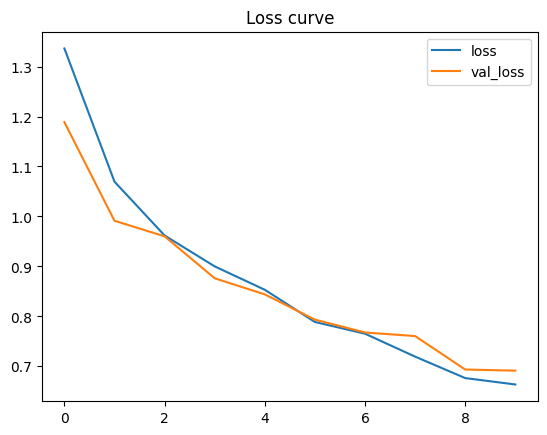

In [37]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

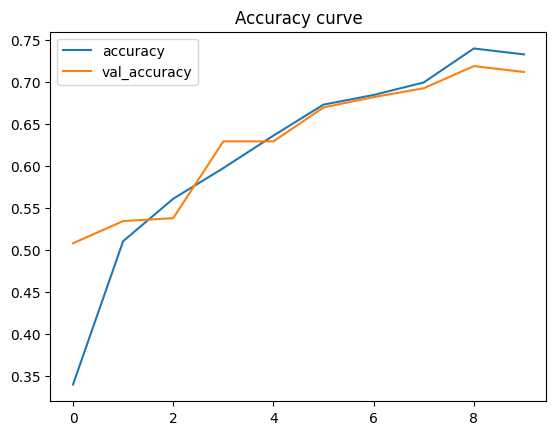

In [38]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

In [39]:
result = model.evaluate(X_test, y_test)

loss = result[0]
accuracy = result[1]
print(f"[+] Accuracy: {accuracy*100:.2f}%")

18/18 [==============================] - 2s 120ms/step - loss: 0.6913 - accuracy: 0.7118
[+] Accuracy: 71.18%


# Архитектура созданной нейронной сети

In [ ]:
model.summary()

# Тестирование на новых примерах

In [46]:
l2[:3]

[1, 3, 1]

In [45]:
X= np.array(l1[:3])
X = X/255

y = encoder.fit_transform(l2[:3])
y = np.array(y)

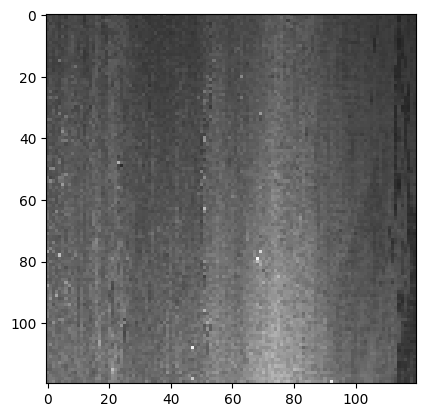

In [47]:
plt.imshow(l1[0]);

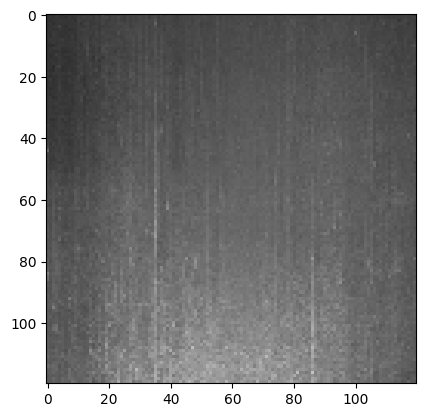

In [48]:
plt.imshow(l1[1]);

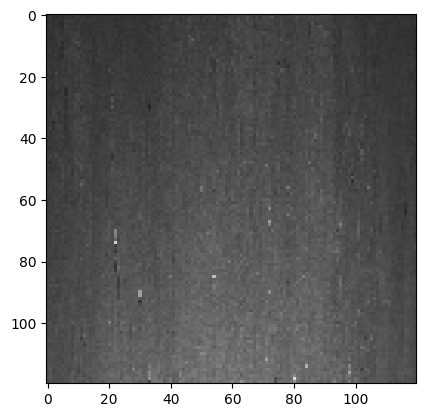

In [49]:
plt.imshow(l1[2]);

In [50]:
y =  to_categorical(y)
y

array([[1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [51]:
predictions = model.predict(X)
predictions

1/1 [==============================] - 0s 192ms/step


array([[0.788236  , 0.03314568, 0.16431952, 0.01429878],
       [0.66723174, 0.07212854, 0.21633552, 0.04430425],
       [0.52859956, 0.0814517 , 0.25469902, 0.1352497 ]], dtype=float32)

Здесь три эксперимента, где мы видим, что тест № 2 был с меткой 3, но неверно идентифицировался как метка 1.

In [ ]:
model.summary()

# описание архитектуры нейронной сети

У нас тут многослойная нейронная сеть с разными типами слоев.

теперь по поводу слоев нейронной сети и их особенностей.

1 слой - Conv2D. Он используется для выполнения двумерной свертки входных данных. Он применяет набор фильтров к входному изображению или карте объектов, перемещая их по входным данным и вычисляя скалярное произведение в каждом месте. Эта операция позволяет слою извлекать объекты и фиксировать пространственные отношения во входных данных. Уровень Conv2D обычно используется в сверточных нейронных сетях (CNN) для таких задач, как классификация изображений, обнаружение объектов и сегментация изображений.

2 слой - MaxPooling2D.  Это  операция понижающей дискретизации, которая уменьшает пространственные размеры (ширину и высоту) входного изображения или карты объектов. Он делит входные данные на непересекающиеся прямоугольники и выводит максимальное значение внутри каждого прямоугольника. Это помогает извлечь наиболее важные функции и снизить вычислительные требования для последующих слоев.

Далее эти слои повторяются еще 2 раза.

7 слой - Flatten. он преобразует входной тензор в одномерный массив, эффективно выравнивая его. Он принимает многомерный входной тензор, например двумерное изображение, и преобразует его в одномерный вектор, который можно использовать в качестве входных данных для полностью связного слоя или любого другого слоя, который ожидает одномерных входных данных.

8 слой - Dense. это полностью связный слой, который соединяет каждый нейрон предыдущего слоя с каждым нейроном текущего слоя. Он выполняет линейную операцию над входными данными, за которой следует функция активации, позволяющая сети изучать сложные закономерности и взаимосвязи в данных. Количество нейронов в плотном слое определяет размерность вывода.

9 cлой - Dropout. это метод регуляризации, используемый для уменьшения переобучения в нейронных сетях. Он случайным образом устанавливает для части входных единиц значение 0 на каждом этапе обучения, что помогает предотвратить слишком большую зависимость сети от конкретных функций или корреляций. Dropout улучшает способность модели к обобщению за счет внесения шума во время обучения и побуждает сеть изучать более надежные и независимые представления.

Далее слои повторяются.

В итоге в данной нейронной сети 12 различных слоев, и 139 780 параметров.